# Significant Wave Height at Bilbao Buoy 

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

os.chdir("C:/Users/user/Victor/Trabajo/ExtremeCorrection/")
sys.path.append(os.path.abspath('C:/Users/user/Victor/Trabajo/ExtremeCorrection/src'))

Load the data

In [2]:
bilbao_buoy_data = np.loadtxt("Data/matriz_13_Boya.txt")

In [3]:
bilbao_buoy_data = bilbao_buoy_data[:,:5]

In [4]:
df_hs = pd.DataFrame({
    "yyyy": bilbao_buoy_data[:,0].astype(np.int64),
    "mm": bilbao_buoy_data[:,1].astype(np.int64),
    "dd": bilbao_buoy_data[:,2].astype(np.int64),
    "hh": bilbao_buoy_data[:,3].astype(np.int64),
    "Hs": bilbao_buoy_data[:,4].astype(np.float64),
    })

In [5]:
df_hs.head()

,yyyy,mm,dd,hh,Hs
0,1985,2,21,9,1.3
1,1985,2,22,9,1.0
2,1985,2,22,12,0.9
3,1985,2,22,15,1.0
4,1985,2,22,18,0.9


## Generate the simulated data with an ARMA

In [39]:
from src.arma_sim import ArmaSimulation

arma = ArmaSimulation(df_hs, var='Hs', freq=365.25*24, distribution="lognorm")
hs_sim = arma.generate_sim(ny_sim = 1000)   # We select the number of years of simulations

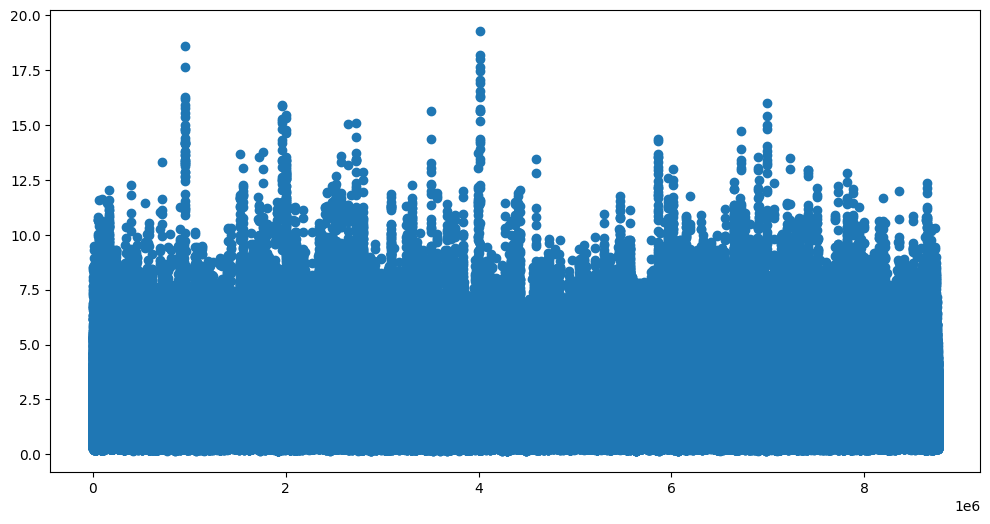

In [40]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(0,1000*24*365.25), hs_sim)
plt.show()

In [41]:
# Starting date within the safe pandas timestamp range
start_date = '2000-01-01 00:00:00'

# Generate date range in 100 years chunks
date_range = pd.date_range(start=start_date, periods=int(365.25*24*100), freq='h')  

In [42]:
sim_yyyy = date_range.year
sim_mm = date_range.month
sim_dd = date_range.day
sim_hh = date_range.hour

In [43]:
year_simulated = np.array([], dtype=np.int32)
month_simulated = np.array([], dtype=np.int32)
day_simulated = np.array([], dtype=np.int32)
hour_simulated = np.array([], dtype=np.int32)
for i in range(len(hs_sim)//len(date_range)):
    year_simulated = np.concatenate([year_simulated, date_range.year + 100*i])
    month_simulated = np.concatenate([month_simulated, date_range.month])
    day_simulated = np.concatenate([day_simulated, date_range.day])
    hour_simulated = np.concatenate([hour_simulated, date_range.hour])

In [44]:
df_sim = pd.DataFrame({
    'yyyy': year_simulated,
    'mm':  month_simulated,
    'dd': day_simulated,
    'hh': hour_simulated,
    'Hs': hs_sim
})

In [45]:
df_sim.head()

,yyyy,mm,dd,hh,Hs
0,2000,1,1,0,1.132710
1,2000,1,1,1,1.086132
2,2000,1,1,2,1.136769
3,2000,1,1,3,0.907946
4,2000,1,1,4,0.836389


## Correction

In [46]:
from extremecorrection import Gev_ExtremeCorrection

In [ ]:
config = {
    'var': 'Hs',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 24*365.25,
    'folder': 'Figures/Hs_Bilbao'
}

Initialize the correction

In [48]:
extr_corr = Gev_ExtremeCorrection(
    data = df_hs,
    config = config,
    conf = 0.95
)

### Apply historical correction

In [49]:
extr_corr.apply_correction(fit_diag=True)   # fit_diag = True, to plot the diagnostics plots (QQ-Plot and PP-plot)
extr_corr.return_period_plot()              # Default to plot only the no corrected data 

In [50]:
extr_corr.gev_parameters    # shape parameter has changed the sign

[5.588346992446635, 0.7762084826818324, -0.09780432912959289]

### Apply simulated correction

In [51]:
extr_corr.apply_correction_sim(simulated_data = df_sim)   # Apply the correction in the simulated data
extr_corr.sim_return_period_plot()                        # Default to plot the corrected and no corrected data
extr_corr.interval_sim_return_period_plot()               # Comparative of no corrected vs corrected simulated data in the historical range
extr_corr.time_series_plot(sim=False)                     # Time series of both corrected and no-corrected data

C:\Users\user\Victor\Trabajo\ExtremeCorrection\src\extremecorrection.py:404: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{self.folder}/Simulation_ReturnPeriod.png", dpi=300)


Dataframe with the corrected simulation

In [52]:
new_sim_data = extr_corr.sim_pit_data_corrected
new_df_sim = df_sim.copy()
new_df_sim['Hs'] = new_sim_data

# PRUEBAS

<Axes: >

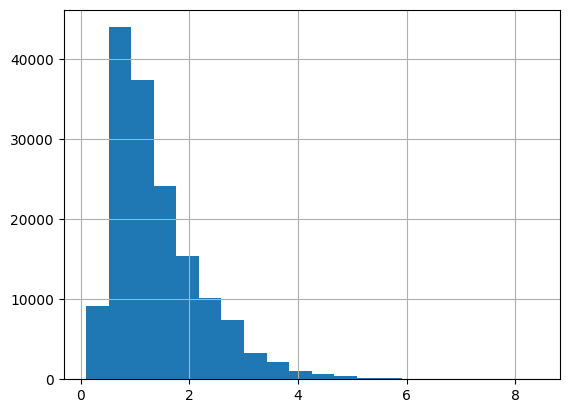

In [53]:
df_hs['Hs'].hist(bins=20)

In [54]:
import scipy.stats as stats

sigma, loc, scale = stats.lognorm.fit(df_hs['Hs'].values)

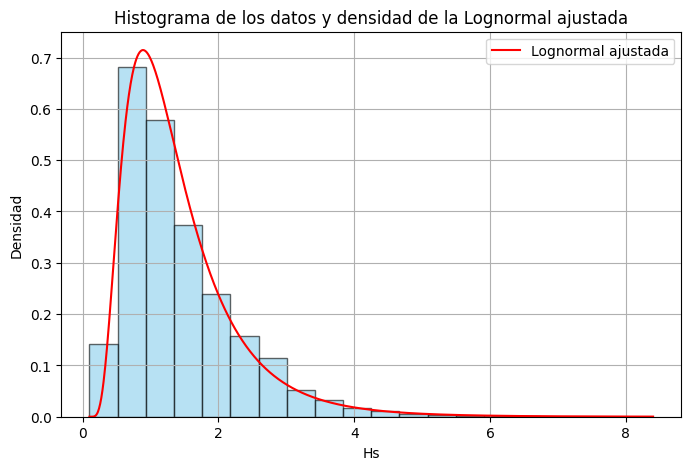

In [55]:
mu = np.log(scale)  # Relación entre scale y mu

# Crear el histograma
plt.figure(figsize=(8, 5))
plt.hist(df_hs['Hs'].values, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Graficar la función de densidad de la lognormal ajustada
x = np.linspace(min(df_hs['Hs'].values), max(df_hs['Hs'].values), 1000)
pdf = stats.lognorm.pdf(x, sigma, loc=loc, scale=scale)
plt.plot(x, pdf, 'r-', label='Lognormal ajustada')

# Etiquetas y leyenda
plt.title('Histograma de los datos y densidad de la Lognormal ajustada')
plt.xlabel('Hs')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()